[ 주택 가격 예측 : 회귀 문제 ]
- 보스턴 주택 가격 데이터 셋
- 범죄율, 지방세율 등의 데이터 => 주택 가격의 중간 값 예측
- 데이터 506개 => train : 404, test : 102
- 입력 데이터에 있는 특성의 스케일(범위)이 각각 다르다


In [1]:
from keras.datasets import boston_housing
import numpy as np

Using TensorFlow backend.


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

[ 데이터 준비 ]
- 데이터 특성의 스케일이 각각 다르다 => 데이터를 특성별로 정규화해준다.


In [3]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /=std

[ 모델 구성 ]
- 64개의 유닛을 가진 2개의 은닉 층
- 마지막 층은 하나의 유닛을 가지고 활성화 함수가 없다.(선형층)
- 손실함수 : mse => 평균제곱오차


In [4]:
from keras import models
from keras import layers

In [5]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

[ K-fold cross-validation ]
- 데이터를 K개로 분할, K개의 모델을 만들어 K-1개의 분할에서 훈련하고 나머지 분할에서 평가
- 모델의 검증 점수 = K개의 검증 점수 평균

In [6]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 10
all_scores = []

for i in range(k):
    print('처리중인 폴드#', i)
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose = 0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드# 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
처리중인 폴드# 1
처리중인 폴드# 2
처리중인 폴드# 3


In [7]:
np.mean(all_scores)

2.6044778534681488

In [8]:
num_epochs = 20
all_mae_histories = []

In [9]:
for i in range(k):
    print('처리중인 폴드#', i)
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data = (val_data, val_targets), epochs=num_epochs, batch_size=1, verbose = 0)
    mae_history = history.history['mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드# 0
처리중인 폴드# 1
처리중인 폴드# 2
처리중인 폴드# 3


In [10]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_mae_history

[10.58911801899227,
 3.627301556049007,
 3.044041454988738,
 2.7266525722572905,
 2.6083736647867135,
 2.4845616593219266,
 2.3540684850302465,
 2.345943049235706,
 2.312428846611048,
 2.237049777909081,
 2.2063259803029176,
 2.173260761172858,
 2.1455939237040655,
 2.0980292763253643,
 2.0823240720792966,
 2.0687316030558973,
 2.0024945968055095,
 2.001052009587241,
 2.002408442717574,
 1.9627540585624894]

In [11]:
import matplotlib.pyplot as plt

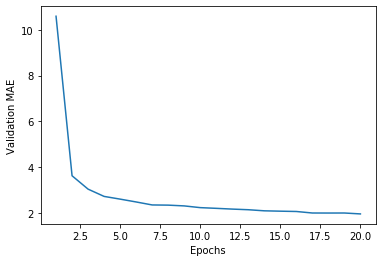

In [12]:
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


#변동이 크다 => 첫 10개의 데이터를 제외
#부드러운 곡선을 위해 지수 이동 편균으로 대체

In [13]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

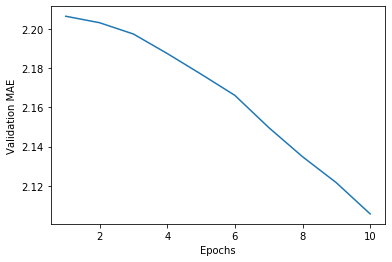

In [14]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [15]:
# 80번부터 overfitting => epochs을 80으로 변경

In [16]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 2ms/step


In [17]:
test_mae_score

2.827495761946136